# CNN-CIFAR-10_이미지분류(다항분류)


## #01. 패키지

In [ ]:
import sys
import os
sys.path.append("/content/drive/MyDrive/DLMLJUPYTER")
import helper_colab
import zipfile

from PIL import Image
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

## #02. 데이터 준비

### 1. 구글 드라이브 연결

Colab의 파일 트리에 `drive`라는 항목이 나타나면 됨

### 2. 이미지 파일 압축 해제 및 data 폴더 생성, 임의의 이미지 확인

압축 파일을 구글 드라이브에 업로드 한 상태에서 수행

#### 각 폴더안에서 임의의 이미지를 추출하여 확인

In [ ]:
# 압축 파일 경로
file_path = "/content/drive/MyDrive/DLMLJUPYTER/CIFAR-10.zip"

# 압축 해제 경로
extract_dir = os.path.join(os.getcwd(), "data")

# 해당 폴더가 없다면 폴더를 생성
if not os.path.exists(extract_dir):
    os.mkdir(extract_dir)

# 파일의 압축 해제
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(extract_dir)
zip_ref.close()

### 3. 파일 경로 확인

#### 압축 해제 폴더 경로 및 훈련/검증용 이미지 폴더 위치 확인

In [ ]:
# 압축 해제 폴더 경로 (data/CIFAR-10)
base_dir = os.path.join(extract_dir, "CIFAR-10")
print(base_dir)

# 훈련 데이터 경로
train_dir = os.path.join(base_dir, "train")
print(train_dir)

# 검증 데이터 경로
test_dir = os.path.join(base_dir, "test")
print(test_dir)

/content/data/CIFAR-10
/content/data/CIFAR-10/train
/content/data/CIFAR-10/test


In [ ]:
# 분류해야할 항목(폴더) 종류
features = os.listdir(train_dir)
print(features) #train 폴더 내부의 폴더

['deer', 'automobile', 'airplane', 'truck', 'ship', 'frog', 'horse', 'dog', 'cat', 'bird']


In [ ]:
for i, v in enumerate(features):
    # 각 폴더의 경로
    target_dir = os.path.join(train_dir, v)
    # print(target_dir) #train 폴더 내부 폴더의 위치

    # 각 폴더별 파일 목록 추출
    file_list = os.listdir(target_dir)
    # print(f"{v} 폴더 파일 :",file_list)

    # 각 폴더별 파일 수
    file_count = len(file_list)
    # print(file_count)

    # subplots 생성
    fig, ax = plt.subplots(1,5, figsize = (10,3))
    fig.suptitle("\"%s\" Folders Image Count : \"%d\""%(target_dir, file_count))

    for k, x in enumerate(ax):
        file_path = os.path.join(target_dir, file_list[k])
        sample = Image.open(file_path)
        x.set_title("%d x %d (px)"%(sample.size[0], sample.size[1]), fontsize=12)
        x.imshow(sample)
        # x.axis('off')


plt.show()
plt.close()

## #03. 데이터 전처리

### 이미지 데이터 증강

`ImageDataGenerator`는 훈련용 이미지가 저장되어 있는 폴더, 검증용 이미지가 저장되어 있는 폴더까지만 전달한다.

`ImageDataGenerator`가 하위 폴더를 식별하여 폴더 안의 항목들을 읽어들인다.

> batch_size가 클 수록 학습 속도는 빨라지지만 정확도는 하락.

> 다중분류 = categorical, 이진 = binary

| 파라미터 | 설명 |
|---|---|
| rescale | 색상에 대한 정규화 처리 |
| rotation_range | 지정된 각도 범위내에서 임의로 원본 이미지를 회전 시킴 |
| width_shift_range | 지정된 값 내에서 임의로 원본 이미지를 수평 이동 시킴 |
| height_shift_range | 지정된 값 내에서 임의로 원본 이미지를 수직 이동 시킴 |
| vertical_flip | `True`인 경우 이미지를 수직 반전 시킴 |
| horizontal_flip | `True`인 경우 이미지를 수평 반전 시킴 |
| validation_split | 훈련용, 검증용을 분할하고자 할 경우 검증용의 비율을 지정 |

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255)   #일반화
test_datagen = ImageDataGenerator(rescale = 1.0/255)   #일반화

train_set = train_datagen.flow_from_directory(train_dir,
                                              classes = features,   # 이미지를 증강시킬 배수
                                              batch_size=5,
                                              class_mode='categorical',
                                              target_size=(32,32)   # 변환될 이미지 해상도(크기)
                                              )

test_set = train_datagen.flow_from_directory(test_dir,
                                              classes = features,   # 이미지를 증강시킬 배수
                                              batch_size=5,
                                              class_mode='categorical',
                                              target_size=(32,32)   # 변환될 이미지 해상도(크기)
                                              )

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [ ]:
print(len(train_set), len(test_set))

10000 2000


## #03. 모델 개발

### 모델 정의

(`Conv2D 적용 [-> BatchNormalization층 적용] -> MaxPool2D 적용 [-> Dropout]`)의 과정을 n번 반복 -> Flatten 레이어 추가 -> Dense층 n개 추가

- **Conv2D 층**
    - 영상이나 이미지의 특징을 확인하기 위한 함수
    - `filters`: 필터(커널)의 개수
    - `kernel_size`: 필터의 크기
    - `strides`: 필터의 이동 간격
    - `padding`: valid(패딩 없음), same(인풋과 아웃풋이 같도록 패딩)
    - `activation`: 활성화 함수
    - `input_shape`: 첫 레이어에 인풋으로 들어오는 크기

- **BatchNormalization (배치정규화)**
    - 신경망 입력데이터를 평균 0, 분산 1로 정규화해서 학습이 잘 이루어지도록 하는 방법
    - BatchNormalization 층에서 정규화를 수행하므로 별도의 정규화를 적용할 필요가 없다.
    - 만약 이 층을 적용하지 않는다면 학습 전에 별도의 정규화를 수행하는 것이 좋다.

- **MaxPool2D**
    - 컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만든다.
    - `pool_size`: 축소시킬 필터의 크기(비율)
    - `strides`: 필터의 이동 간격. 기본값으로 pool_size를 갖는다.
    - 일반적으로 strides는 pool_size와 동일하게 적용되므로 생략하는 편.


 > filter가 클수록, kernel_size가 작을 수록 모델이 성능이 개선됨.
 단, 학습 시간도 오래 걸림.

> activation : 다중분류 = softmax, unit 10, 이진분류 = sigmoid, unit 1/0 - 주로 `relu`

> loss : 다중분류 = categorical_crossentropy, 이진분류 = binary_crossentropy

> Sequential : 모델을 하나 하나 차례로 집어 넣는다

> Dense : 완전 연결 층

> optimizer : 경사하강법 변화 버전(sgd, adam 등등)

> metrics : 평가지표(학습 판단 기준) mse, mae, acc 등

In [ ]:
model = Sequential()

# ------------------------#
# 1차
# ------------------------#
model.add(Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3))) #컬러 이미지는 3차원
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# 랜덤으로 25%의 뉴런을 쉬게함  #속도는 향상, 성능은 저하(순수 성능을 위한 명령어)
model.add(Dropout(0.25))

# ------------------------#
# 2차
# ------------------------#
model.add(Conv2D(filters=32, kernel_size=(4,4), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# ------------------------#
# 3차
# ------------------------#
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# ------------------------#
# 4차
# ------------------------#
model.add(Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))    #다중불류 softmax
model.add(Dense(10, activation='softmax'))  #

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        1216      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        8224      
                                                                 
 batch_normalization_2 (Bat  (None, 16, 16, 32)       

### 학습하기

- epochs는 많아도 크게 상관이 없음(단, 너무 크면 오래 걸리고 오차가 증가)
    - callback을 사용해 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링
    - EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ReduceLROnPlateau EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ModelCheckpoint 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

In [ ]:
%%time

result = model.fit(train_set, epochs=500, validation_data=test_set, callbacks=[
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
10000/10000 [==============================] - 119s 10ms/step - loss: 1.6720 - acc: 0.3994 - val_loss: 3.6332 - val_acc: 0.3058 - lr: 0.0010
Epoch 2/500
10000/10000 [==============================] - 98s 10ms/step - loss: 1.3837 - acc: 0.5028 - val_loss: 1.3937 - val_acc: 0.5287 - lr: 0.0010
Epoch 3/500
10000/10000 [==============================] - 93s 9ms/step - loss: 1.2617 - acc: 0.5482 - val_loss: 1.1689 - val_acc: 0.5878 - lr: 0.0010
Epoch 4/500
10000/10000 [==============================] - 96s 10ms/step - loss: 1.1764 - acc: 0.5803 - val_loss: 1.1256 - val_acc: 0.6100 - lr: 0.0010
Epoch 5/500
10000/10000 [==============================] - 92s 9ms/step - loss: 1.1146 - acc: 0.6031 - val_loss: 1.1060 - val_acc: 0.6275 - lr: 0.0010
Epoch 6/500
10000/10000 [==============================] - 88s 9ms/step - loss: 1.0721 - acc: 0.6216 - val_loss: 0.9870 - val_acc: 0.6600 - lr: 0.0010
Epoch 7/500
10000/10000 [==============================] - 91s 9ms/step - loss: 1.0341 - a

## #04. 학습 결과 평가

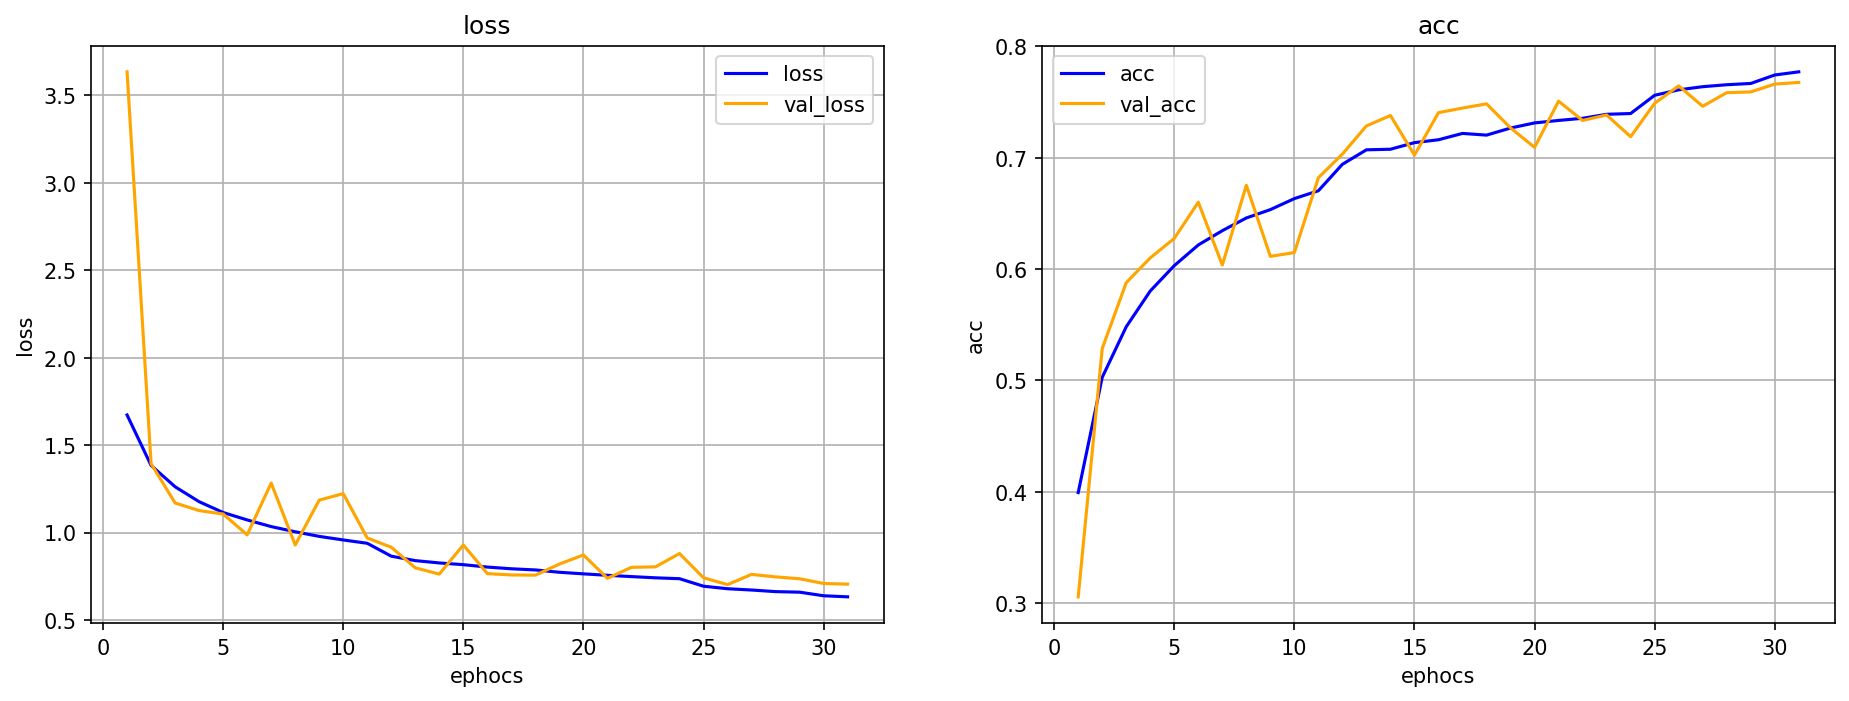

In [ ]:
# helper_colab.tf_result_plot(result)
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)

# 학습 결과 그래프의 컬럼 명
column_names = result_df.columns

# 학습데이터에 대한 필드이름
train_column_name = [column_names[0], column_names[1]]

# 검증데이터에 대한 필드이름
test_column_name = [column_names[2], column_names[3]]

# 학습 결과 그래프

# # 그래프 객체 생성
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=150)

# # 훈련 및 검증 데이터의 손실률, 절대오차 그래프 그리기
for i, v in enumerate(ax):
    sb.lineplot(x=result_df.index, y=train_column_name[i], data=result_df, color='blue', label=train_column_name[i], ax=v)
    sb.lineplot(x=result_df.index, y=test_column_name[i], data=result_df, color='orange', label=test_column_name[i], ax=v)
    v.set_title(train_column_name[i])
    v.set_xlabel('ephocs')
    v.set_ylabel(train_column_name[i])
    v.grid()
    v.legend()

plt.show()
plt.close()

In [ ]:
evaluate1 = model.evaluate(train_set)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(test_set)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

10000/10000 [==============================] - 51s 5ms/step - loss: 0.3552 - acc: 0.8764
최종 훈련 손실률: 0.355248, 최종 훈련 정확도: 0.876440
2000/2000 [==============================] - 10s 5ms/step - loss: 0.7051 - acc: 0.7675
최종 검증 손실률: 0.705138, 최종 검증 정확도: 0.767500


## #05. 학습 결과 적용

### 훈련 데이터에 대한 예측 결과를 산정

In [ ]:
pred = model.predict(train_set)
data_count, case_count = pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
pred[0]

10000/10000 [==============================] - 41s 4ms/step
50000개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([3.69332242e-03, 1.41673581e-05, 1.00931255e-04, 3.92242800e-05,
       9.13596232e-05, 5.53603331e-03, 1.44612364e-04, 9.32997942e-01,
       5.38792349e-02, 3.50318942e-03], dtype=float32)

### 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [ ]:
pred_result = np.argmax(pred, axis=-1)
pred_result

array([7, 0, 3, ..., 6, 0, 9])

### 각 종속변수별로 레이블링이 어떻게 되어 있는 확인

In [ ]:
class_names = list(train_set.class_indices.keys())
class_names

['deer',
 'automobile',
 'airplane',
 'truck',
 'ship',
 'frog',
 'horse',
 'dog',
 'cat',
 'bird']

In [ ]:
img, label = train_set[0]
label

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

### 훈련용 이미지에 대한 예측결과 확인

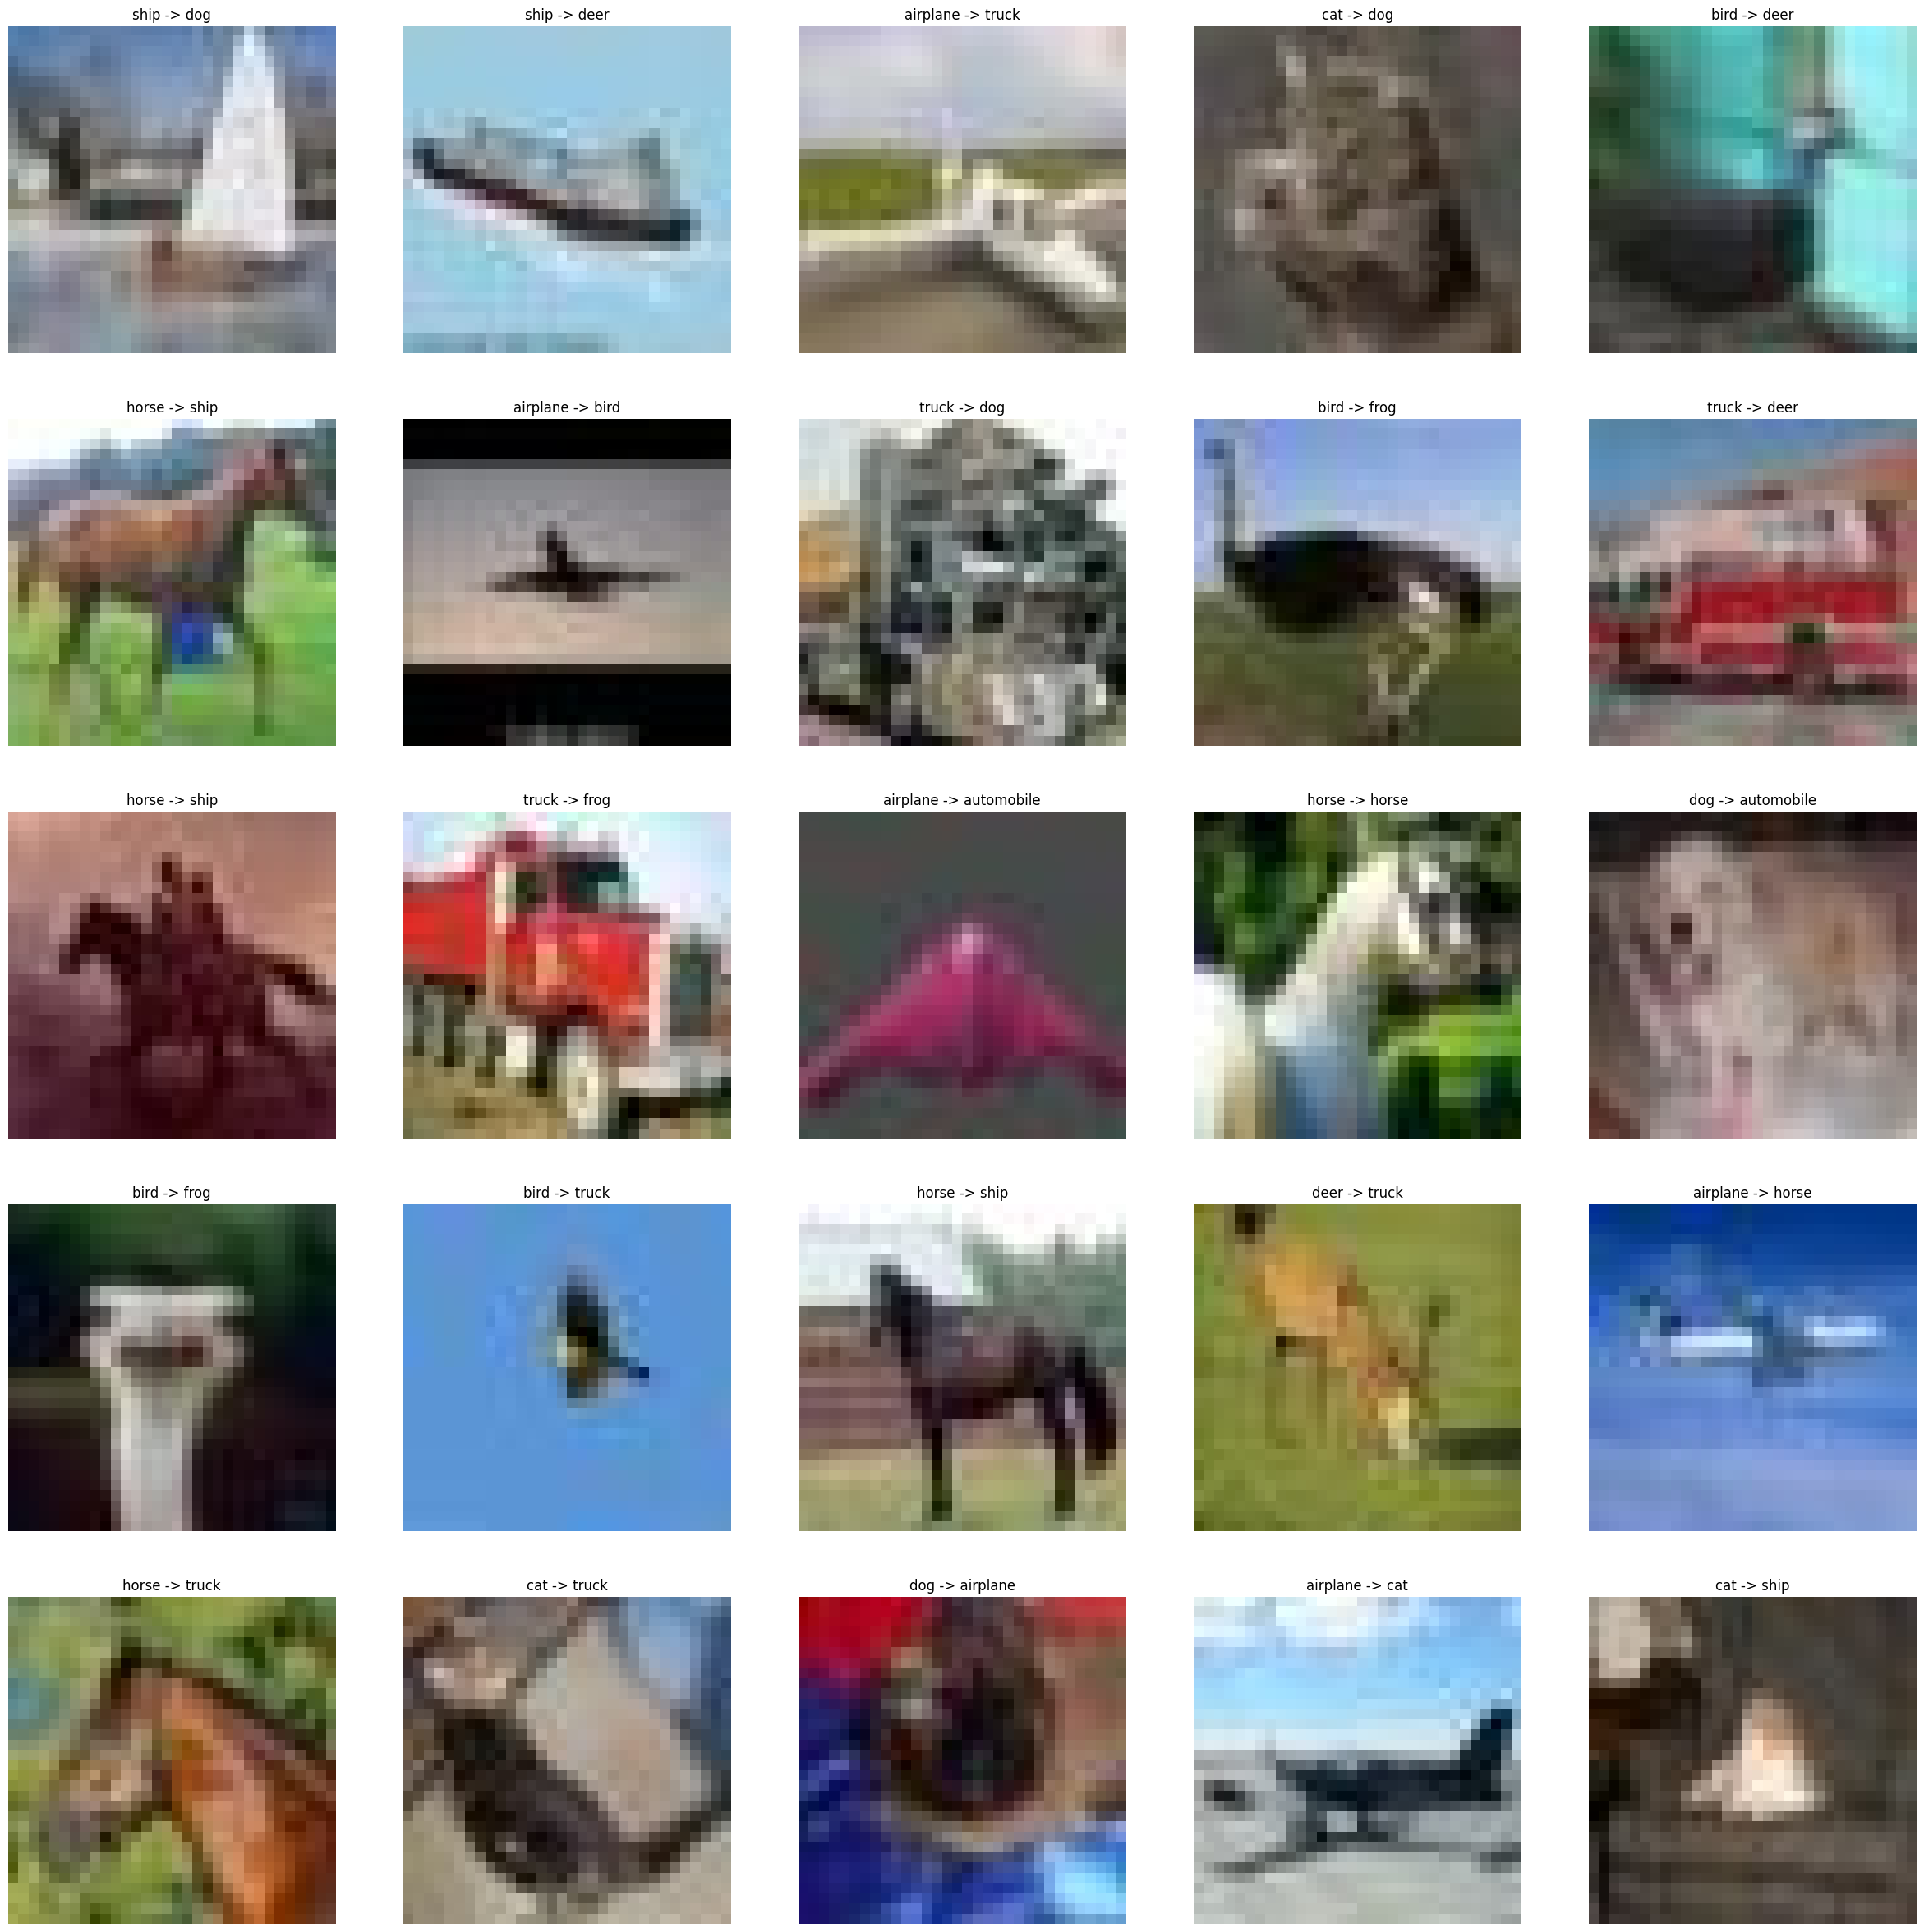

In [ ]:
row = 5 # 내가 몇 줄을 출력하고 싶은지 지정
col = train_set.batch_size  # batch-size에 맞춰서 지정 (값이 너무 클 경우 반복문 로직을 따로 적용)
fig, ax = plt.subplots(row, col, figsize=((col+1)*5, (row+1)*5))

k = 0

for i in range(0, row):
    # batch_size 만큼의 첫 번째 이미지 묶음을 반환
    # -> img와 label의 길이는 col과 동일하다.
    img, label = train_set[i]

    for j in range(0, col):
        # 종속변수인 label은 one-hot-encoding 형태로 반환되므로 몇 번째 인덱스가 `1`인지 찾아야 한다.
        label_max = np.argmax(label[j], axis=-1)

        ax[i][j].imshow(img[j])
        ax[i][j].set_title("%s -> %s" % (class_names[label_max], class_names[pred_result[k]]))
        ax[i][j].axis('off')
        k += 1

plt.show()
plt.close()

### 혼동행렬

In [ ]:
train_set.labels

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [ ]:
cm = confusion_matrix(train_set.labels, pred_result)
cmdf2 = DataFrame(cm, columns=list(map(lambda x: "(r)%s" % class_names[x], range(10))), index=list(map(lambda x: "(p)%s" % class_names[x], range(10))))
cmdf2

,(r)deer,(r)automobile,(r)airplane,(r)truck,(r)ship,(r)frog,(r)horse,(r)dog,(r)cat,(r)bird
(p)deer,515,475,544,482,513,606,527,456,416,466
(p)automobile,550,542,521,486,543,551,481,488,387,451
(p)airplane,517,526,549,464,513,578,486,454,448,465
(p)truck,543,487,516,475,485,585,490,447,476,496
(p)ship,559,489,506,500,553,542,479,456,442,474
(p)frog,546,519,483,495,473,610,473,468,462,471
(p)horse,534,445,496,453,561,617,494,473,442,485
(p)dog,590,514,503,434,519,570,513,470,422,465
(p)cat,528,480,521,460,545,563,514,474,426,489
(p)bird,532,518,497,495,478,565,516,446,460,493


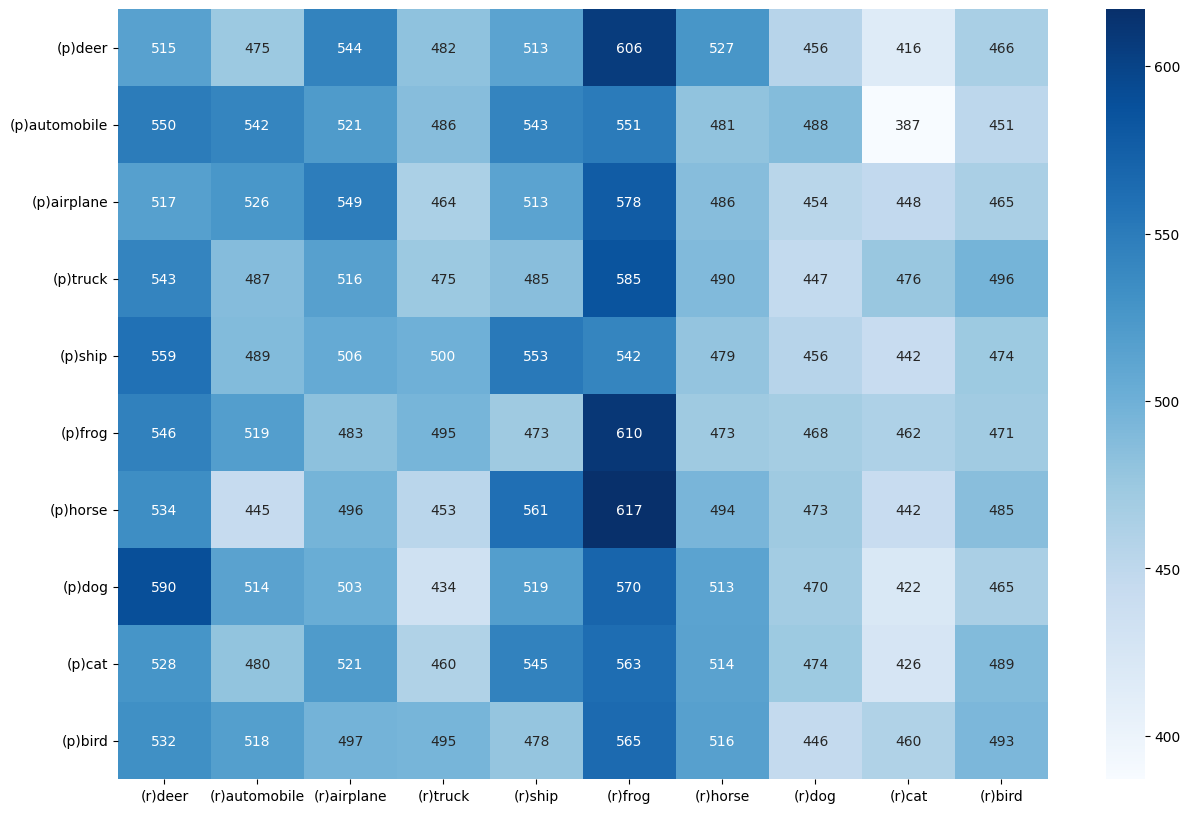

In [ ]:
plt.figure(figsize=(15, 10))
sb.heatmap(cmdf2, annot = True, fmt = 'd', cmap = 'Blues')
plt.show()
plt.close()